# 勾配法と誤差逆伝播法
ニューラルネットワークにおいて，効率よく各重みの勾配を推定することで貢献度割り当て問題を解決する方法が**誤差逆伝播法** (backpropagation) である．本節では入力層，隠れ層，出力層からなる多層ニューラルネットワークを実装し，誤差逆伝播法による勾配推定を用いて学習を行う．

本書では誤差逆伝播法を用いない学習法を実施することも考慮し，数式と対応するような実装を行う．そのため，Deep Learningライブラリ (PyTorch, Flux.jl等) のようにLayerを定義し，それを繋げてモデルを定義するということや計算グラフの構築は行わない．

In [140]:
using Base: @kwdef
#using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter
#using BenchmarkTools; @btime

活性化関数 (activation function) の構造体を`ActivationFunction` と定義する．この構造体には`forward` と `backward`の2種類の関数フィールド (field; 構造体の要素のこと) を持たせておく．2種類の関数はそれぞれ順伝播時と逆伝播時に使用する．

In [141]:
struct ActivationFunction
    forward::Function   # function for forward propagation
    backward::Function  # function for back-propagation
end

また，次のコードにより，構造体のインスタンスを関数として使用できるようにしておく．これはcallable objectと呼ばれる．

In [142]:
(f::ActivationFunction)(x) = f.forward(x)

代表的な活性化関数を紹介する．なお，`backward` における `y` は `forward` での出力に対応する．これは活性化関数を作用させる前の変数 ($x$であり，膜電位に対応する) を保持しておかなくても良いようにするためである．Sigmoid関数の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{1}{1+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{e^{-x}}{(1+e^{-x})^2}= y\cdot (1-y)\\
\end{align}
$$

tanh関数の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{e^x-e^{-x}}{e^x+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{(e^x+e^{-x})(e^x+e^{-x})-(e^x-e^{-x})(e^x-e^{-x})}{(e^x+e^{-x})^2}= 1-y^2\\
\end{align}
$$

ReLU関数 (rectified linear unit, 正規化線形関数) の場合，

$$
\begin{align}
&\textrm{forward: } y = \max(x, 0)\\
&\textrm{backward: } \frac{dy}{dx} = \mathbf{1}_{x > 0}(x) = \mathbf{1}_{y > 0}(y)\\
\end{align}
$$

ただし，$\max(a, b)$は, $a, b$のうち，大きい値を返す関数である．また，$\mathbf{1}_{A}(x)$ は指示関数 (indicator function)であり，$x\in A$ ならば $\mathbf{1}_A(x)=1$ であり，それ以外の場合は $\mathbf{1}_A(x)=0$ となる関数である．ReLU関数は $x=0$ で折れ曲がるが，その他では線形であるため，区分線形関数 (piecewise linear function) の一種であると言える．

これらの活性化関数を構造体 `ActivationFunction`を用いて実装する．

In [143]:
Sigmoid = ActivationFunction(
    x -> 1.0 ./ (1.0 .+ exp.(-x)),
    y -> y .* (1 .- y)
)

Tanh = ActivationFunction(
    x -> tanh.(x),
    y -> 1 .- y .^ 2
)

Relu = ActivationFunction(
    x -> max.(0, x),
    y -> y .> 0
)

Identity = ActivationFunction(
    x -> x, # or use `identity` function
    y -> fill!(similar(y), 1)
);

ニューラルネットワークのパラメータを保持する構造体を定義する．

In [144]:
abstract type NeuralNet end
(f::NeuralNet)(x) = forward!(f, x)

ニューラルネットワーク内の学習可能なパラメータ (learnable parameter) を保持する構造体を定義する．各パラメータはそれ自体の値 (value) と損失関数に対する勾配 (gradient) を持つ．

In [145]:
mutable struct Param
    v::Array
    grad::Array

    Param(value) = new(value, zero(value))
end

In [146]:
struct MLP <: NeuralNet
    L::Int # num. of layers
    W::Vector{Param}; b::Vector{Param}   # weights and bias
    z::Vector{Array}; δ::Vector{Array}   # state of forward/backward activity
    f::Vector{ActivationFunction} # activation functions of layers

    function MLP(n_units::Vector{Int}; f_hid::ActivationFunction=Sigmoid, f_out::ActivationFunction=Identity)
        L = length(n_units) - 1
        # initialization of parameters
        W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1]))) for l in 1:L] # Xavier
        b = [Param(zeros(1, n_units[l+1])) for l in 1:L]
        
        # initialization of forward / backward states
        z, δ = Vector{Array}(undef, L+1), Vector{Array}(undef, L)
        f = vcat([repeat([f_hid], L-1)..., f_out])
        new(L, W, b, z, δ, f)
    end
end

struct `MLP`を用意し，**重みの初期化(weight initialization)** を行う同名の関数`MLP`を用意する．重みの初期化に関しては，各層の出力および勾配の分散が一定となるような初期化をすることで学習が進行することが知られている．出力は活性化関数に依存するため，初期化についても活性化関数に応じて変更することが推奨され，sigmoid関数やtanh関数を用いる場合はXavierの初期化 \citep{Glorot2010-iu}，ReLU関数を用いる場合はHeの初期化 \citep{He2015-fs} が用いられる．入力ユニット数を $n_{\textrm{in}}$, 出力ユニット数を $n_{\textrm{out}}$ とすると，Xavierの初期化では重み $w$ の平均が0, 分散が $\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}$ となるように一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}, \sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ 等から重みをサンプリングする．Heの初期化ではReLUを用いる場合，重み $w$ の平均が0, 分散が$\frac{2}{n_{\textrm{in}}}$ あるいは $\frac{2}{n_{\textrm{out}}}$ となるようにし，前者の分散を使用する場合は一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}}}, \sqrt{\frac{6}{n_{\textrm{in}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}}}\right)$ 等から重みをサンプリングする．

### 順伝播 (forward propagation)
$f(\cdot)$を活性化関数とする．順伝播(feedforward propagation)は以下のようになる．$(\ell=1,\ldots,L)$

$$
\begin{align}
\text{入力層 : }&\mathbf{z}_1=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell\\
&\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}_{L+1}
\end{align}
$$

実装における取り回しの都合上，以下では$f:=f_\ell\ (1, \ldots, L-1)$ とし，$g:=f_{L}$ は損失関数において記述されることとする．以下では`z[l]`は$\mathbf{z}_\ell \ (1, \ldots, L)$に対応するが，`z[L+1]`は$\mathbf{z}_{L+1}$ではなく$\mathbf{a}_{L}$に対応することに注意．

とするか？混乱をきたしかねないし，余計な計算が増える．softmaxをどうするか．

In [147]:
# forward computation of MLP
function forward!(mlp::MLP, x::Array)
    (;L, f, W, b, z) = mlp
    z[1] = x # input (n_batch x n_neurons)
    for l in 1:L
        z[l+1] = f[l](z[l] * W[l].v .+ b[l].v) # hidden layers
    end
    return z[L+1] # output
end

forward! (generic function with 1 method)

`W[l].v` は`l`番目の`Param`のインスタンスにおける`v`を取り出す操作である．

### 逆伝播 (backward propagation)
ニューラルネットワークの学習 (learning) あるいは訓練 (training) とは，目的関数 (objective function) あるいは損失関数 (loss function) と呼ばれる評価指標を可能な限り小さく (場合によっては大きく) するようなパラメータ集合 $\Theta = \{W_\ell, b_\ell\}_{\ell=1}^{L}$ を求める過程のことである．学習においてパラメータを最適化するアルゴリズムを**オプティマイザ** (optimizer) という．オプティマイザは多数提案されており，代表的なものを後ほど紹介する．まず，最も単純なオプティマイザである **勾配降下法** (gradient descent; GD) を紹介する．勾配降下法では全データを用いてパラメータ $\theta \in \Theta$ の更新量 $\Delta \theta$ を 

$$
\Delta \theta = -\eta \frac{\partial \mathcal{L}_{\textrm{GD}}}{\partial \theta} = -\frac{\eta}{N} \sum_{i=1}^N \frac{\partial \mathcal{L}^{(i)}}{\partial \theta}
$$

として計算する (パラメータは$\theta\leftarrow \theta + \Delta \theta$により更新される)．ただし，$\mathcal{L}_{\textrm{GD}}:=\frac{1}{N}\sum_{i=1}^N \mathcal{L}^{(i)}$ であり，$\mathcal{L}^{(i)}$は$i$ 番目のサンプルに対する目的関数であり，$N$ は全データのサンプル数を意味する．$\eta$ は学習率 (learning rate) である．オプティマイザは一般的に勾配 $\dfrac{\partial \mathcal{L}}{\partial \theta}$ の計算を必要とする．この計算を効率よく行う手法が**誤差逆伝播法** (backpropagation) である．誤差逆伝播法は連鎖律 (chain rule; 合成関数の微分の関係式) を用いて導くことができる．$\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell$ および $\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)$ であることを踏まえると，

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}\\
\delta_L&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}\\
\mathbf{\delta}_\ell&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\ell+1}} \frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_\ell}\\
&=\left(\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell+1}}\frac{\partial \mathbf{a}_{\ell+1}}{\partial \mathbf{z}_{\ell+1}}\right)\frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_{\ell}}\\
&={W_{\ell+1}}^\top \delta_{\ell+1} \odot f_\ell^{\prime}\left(\mathbf{a}_{\ell}\right)\\
\frac{\partial \mathcal{L}}{\partial W_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial W_\ell}=\delta_\ell \mathbf{z}_\ell^\top\\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial \mathbf{b}_\ell}=\delta_\ell
\end{align}
$$

が成り立つ．バッチ処理を考慮すると，行列を乗ずる順番が変わる．以下では$z=f(a), g(z)=f'(a)$として膜電位を使わず，発火率情報のみを使うようにしている．このようにできない関数もあるが，今回はこのように書き下せる活性化関数のみを扱う．

In [148]:
function backward!(mlp::MLP)
    (;L, W, b, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        if l < L
            δ[l] = δ[l+1] * W[l+1].v' .* f[l].backward(z[l+1])
        end
        W[l].grad = z[l]' * δ[l] / n_batch
        b[l].grad = sum(δ[l], dims=1) / n_batch
    end
end

backward! (generic function with 1 method)

### 損失関数
回帰問題において，代表的に用いられるのが平均二乗誤差 (mean squared error) である．

$$
\begin{align}
\hat{\mathbf{y}} &= \mathbf{z}_{L+1}\\
\mathcal{L}&:=\frac{1}{2}\left\|\hat{\mathbf{y}}-\mathbf{y}\right\|^{2}\\
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}=\hat{\mathbf{y}}-\mathbf{y}\\
\delta_L&=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}=\left(\hat{\mathbf{y}}-\mathbf{y}\right) \odot f_L^{\prime}\left(\mathbf{a}_L\right)\\
\end{align}
$$

In [149]:
function squared_error!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = sum(error .^ 2) / n_batch
    δ[end] = error .* f[end].backward(ŷ)
    return loss
end

squared_error! (generic function with 1 method)

2クラス分類で用いられるのがバイナリ交差エントロピー (binary cross entropy) である．

In [150]:
clog(x) = max(log(x), -1e2) # clamped log

function binary_crossentropy!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    @assert f[end] == Sigmoid # f[end] must be sigmoid function
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = -sum(-y .* clog.(ŷ) + (1 .- y) .* clog.(1 .- ŷ)) / n_batch
    δ[end] = error
    return loss
end

binary_crossentropy! (generic function with 1 method)

多クラス分類課題で用いられるのが，softmaxおよびcross entropy lossである．
softmax関数は $\mathbf{y} = \text{softmax}(\mathbf{z})$ とすると，各成分を以下のように定義される．

$$
\begin{equation}
y_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
\end{equation}
$$

In [151]:
function softmax(x; dims=2)
    expx = exp.(x .- maximum(x, dims=dims))
    return expx ./ sum(expx, dims=dims)
end

# t: labels (1 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Vector)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = length(t)
    idx = CartesianIndex.([(i, t[i]) for i in 1:n_batch])
    loss = -sum(clog.(ŷ[idx])) / n_batch
    grad = copy(ŷ)
    grad[idx] .-= 1
    δ[end] = grad / n_batch
    return loss
end

# t: probability (2 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Array)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = size(t)[1]
    loss = -sum(t .* clog.(ŷ)) / n_batch
    δ[end] = (ŷ - t) / n_batch
    return loss
end

cross_entropy_loss! (generic function with 2 methods)

Softmaxのbackwardは基本的に使用しないため，適当に`identity`関数などを入れておく．

In [152]:
Softmax = ActivationFunction(softmax, identity);

In [153]:
mlp = MLP([10, 20, 5], f_hid=Sigmoid, f_out=Softmax)

MLP(2, Param[Param([-0.40672695398991143 0.3263507577985013 … 0.43896235956757323 -0.0011998306261991772; -0.18195248989655954 0.33268627335920914 … -0.34752770091573315 -0.2957298435348098; … ; -0.13065632553689707 -0.2369085987317641 … -0.23431302612062413 -0.3906115528673419; 0.38951954845048314 -0.17779469056812644 … 0.09079456881363937 0.29213168520128935], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), Param([-0.18084244571327499 -0.17745355880994454 … -0.3168667494696531 0.3016431038606126; -0.19539931347577683 0.04260559690587564 … -0.32566494398139767 -0.18423470915570012; … ; 0.44677212297228525 -0.18102082007464032 … 0.2313038901279935 0.17484720109785823; -0.26339054689748453 0.2919103924772889 … 0.3587264748556328 0.04355051545977721], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])], Param[Param([0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0]), Param([0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0])], Array[#undef, #u

In [154]:
x = rand(3, 10)
z = mlp(x)
t = [1, 3, 4]

3-element Vector{Int64}:
 1
 3
 4

In [155]:
loss = cross_entropy_loss!(mlp, t)

1.5123070926527504

In [156]:
backward!(mlp)

### オプティマイザ
abstract typeとして`Optimizer`タイプを作成する．

In [157]:
abstract type Optimizer end

勾配降下法は$N$が大きい場合，あるいは1つのサンプルのデータサイズが大きい場合は非効率であるので，ニューラルネットワークの学習においては，データの部分集合であるミニバッチ (mini-bacth) を用いた **確率的勾配降下法** (stochastic gradient descent; SGD) が用いられる．
**確率的勾配降下法(stochastic gradient descent; SGD)** を実装する．

In [158]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    η::FT=1e-2
end

function optimizer_update!(param::Param, optimizer::SGD)
    (;η) = optimizer
    param.v -= η * param.grad
end

optimizer_update! (generic function with 2 methods)

次に**Adam** {cite:p}`Kingma2014-fm` を実装する．

In [159]:
# Adam optimizer
@kwdef mutable struct Adam{FT} <: Optimizer
    α::FT= 1e-4; β1::FT = 0.9; β2::FT = 0.999; ϵ::FT = 1e-8
    ms = Dict(); vs = Dict();
end

# Adam optimizer
function optimizer_update!(param::Param, optimizer::Adam)
    (;α, β1, β2, ϵ, ms, vs) = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zero(param.v), zero(param.v)
    end    
    m, v = ms[key], vs[key]
    m += (1 - β1) * (param.grad - m)
    v += (1 - β2) * (param.grad .* param.grad - v)
    param.v -= α * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

In [160]:
function optim_step!(nn::NeuralNet, optimizer::Optimizer)
    (;L, W, b) = nn
    for param in [W, b]
        for p in param
            optimizer_update!(p, optimizer)
        end
    end
end

optim_step! (generic function with 1 method)

In [161]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function, optimizer::Optimizer=SGD())
    #ŷ = forward!(nn, x)
    _ = nn(x)
    loss = loss_fun(nn, y)
    backward!(nn)
    optim_step!(nn, optimizer) # update params
    return loss
end

train_step! (generic function with 2 methods)

## Zipser-Andersenモデル
Zipser-Andersenモデル {cite:p}`Zipser1988-nc` は頭頂葉の7a野のモデルであり，網膜座標系における物体の位置と眼球位置を入力として，頭部中心座標(head centered coordinate)に変換する．隠れ層はPPC(Posterior parietal cortex)の細胞のモデルになっている．

### データセットの生成
物体位置の表現にはGaussian形式とmonotonic形式があるが，簡単のために，Gaussian形式を用いる．なお，monotonic形式については末尾の補足を参照してほしい．

In [162]:
# Gaussian 2d
function Gaussian2d(pos, sizex=8, sizey=8, σ=1)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = [i for i in x, j in 1:length(y)], [j for i in 1:length(x), j in y]
    x0, y0 = pos
    return exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / 2σ^2)
end

Gaussian2d (generic function with 4 methods)

入力は64(網膜座標系での位置)+2(眼球位置信号)=66とする．眼球位置信号は原著ではmonotonic形式による32(=8ユニット×2(x, y方向)×2 (傾き正負))ユニットで構成されるが，簡単のために眼球位置信号も$x, y$の2次元とする．視覚刺激は-40度から40度までの範囲であり，10度で離散化する．よって，網膜座標系での位置は$8\times 8$の行列で表現される．位置は2次元のGaussianで表現する．ただし，1/e幅（ピークから1/eに減弱する幅）は15度である．$1/e$の代わりに$1/2$とすれば半値全幅(FWHM)となる．スポットサイズを$W$，Gaussianを$G(x)$とすると．$G(x+w/2)=G/e$より，$\sigma=\frac{\sqrt{2}w}{4}$と求まる．

In [173]:
# dataset θeter
θmax = 40.0 # degree, θ∈[-θmax, θmax]
Δθ = 10.0 # degree
stimuli_size = Int(2θmax / Δθ)
w = 15.0 # degree; 1/e width
σ = √2w/(4Δθ);

# training θeter
n_data = 5000
n_traindata = Int(n_data*0.9)
n_batch = 100 # batch size
n_iter_per_epoch = Int(n_traindata/n_batch)
n_epoch = 500; # number of epoch

In [174]:
# generate positions
Random.seed!(0)
retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
#retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
#head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
eye_pos = head_centered_pos - retinal_pos; # ∈ [-80, 80]

# convert
input_retina = [hcat(Gaussian2d((retinal_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data];
input_retina = vcat(input_retina...)
eye_pos /= 2θmax;

# concat
x_data = hcat(input_retina, eye_pos) #_encoded)
y_data = vcat([hcat(Gaussian2d((head_centered_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data]...);

# split
x_traindata, y_traindata = x_data[1:n_traindata, :], y_data[1:n_traindata, :]
x_testdata, y_testdata = x_data[n_traindata+1:end, :], y_data[n_traindata+1:end, :];

In [175]:
product(sets...) = hcat([collect(x) for x in Iterators.product(sets...)]...)' # Array of Cartesian product of sets 

product (generic function with 1 method)

モデルの定義を行う．

In [176]:
# model θeter
n_in = stimuli_size^2 + 2 # number of inputs
n_hid = 16   # number of hidden units
n_out = stimuli_size^2   # number of outputs
η = 1e-2  # learning rate

0.01

In [177]:
nn = MLP([n_in, n_hid, n_out], f_hid=Sigmoid, f_out=Sigmoid)
#optimizer = SGD(η=η);
loss_fun = binary_crossentropy!
#loss_fun = squared_error!#binary_crossentropy!
optimizer = Adam();

学習を行う．

In [178]:
error_arr = zeros(n_epoch); # memory array of each epoch error

@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = x_traindata[idx, :], y_traindata[idx, :]
        loss = train_step!(nn, x, y, loss_fun, optimizer)
        error_arr[e] += loss
    end 
    error_arr[e] /= n_traindata
end

Training... 100%|████████████████████████████████████████| Time: 0:00:06


損失の変化を描画する．

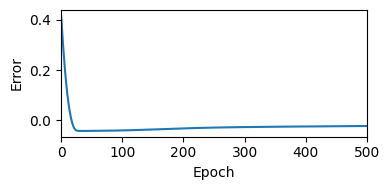

In [179]:
figure(figsize=(4,2))
#semilogy(error_arr)
plot(error_arr)
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

テストデータを用いて，出力を確認する．

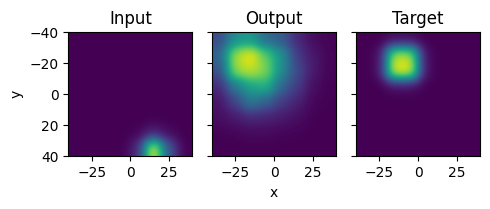

In [180]:
x, y = x_testdata[1:2, :], y_testdata[1:2, :]
ŷ = forward!(nn, x)

id = 1
plot_data = [
    reshape(x[id, 1:64], (stimuli_size, stimuli_size))',
    reshape(ŷ[id, :], (stimuli_size, stimuli_size))',
    reshape(y[id, :], (stimuli_size, stimuli_size))'
    ]
titles = ["Input", "Output", "Target"]
fig, axes = subplots(1, 3, figsize=(5,2), sharey=true)
for i in 1:3
    axes[i].set_title(titles[i])
    axes[i].imshow(plot_data[i], interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
end
axes[1].set_ylabel("y"); 
axes[2].set_xlabel("x"); 
tight_layout()

重み`W1`におけるゲインフィールドの描画を行う．

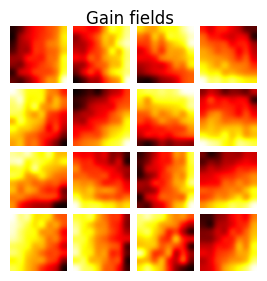

In [181]:
# Plot Gain fields
figure(figsize=(3.2, 3))
suptitle("Gain fields", fontsize=12)
subplots_adjust(hspace=0.1, wspace=0.1, top=0.925)
for i in 1:n_hid
    #subplot(3, 3, i)
    subplot(4, 4, i)
    imshow(reshape(nn.W[1].v[1:stimuli_size^2, i], (stimuli_size, stimuli_size)), cmap="hot", interpolation="gaussian")
    axis("off")
end

補足としてMonotonic formatによる位置のエンコーディングに触れる．monotonic形式を入力の眼球位置と出力の頭部中心座標で用いるという仮定には，視覚刺激を中心窩で捉えた際，得られる眼球位置信号を頭部中心座標での位置の教師信号として使用できるという利点がある．\citep{Andersen1983-zp} では Parietal visual neurons (PVNs)の活動を調べ，傾き正あるいは負．0度をピークとして減少あるいは上昇の4種類あることを示した．前者は一次関数（とReLU関数）で記述可能である．

In [50]:
get_line(p1, p2) = [(p2[2]-p1[2])/(p2[1]-p1[1]), (p2[1]*p1[2] - p1[1]*p2[2])/(p2[1]-p1[1])] # [slope, intercept]
eye_pos_coding(x; linear_θ) = Relu.(linear_θ[1, :] * x .+ linear_θ[2, :])

x = -2θmax:1:2θmax
slope_θ = hcat([get_line([80, 1], [-80, -2(i-1)/stimuli_size]) for i in 1:stimuli_size]...)
y = hcat(eye_pos_coding.(x; linear_θ=slope_θ)...)
eye_pos_encoded = eye_pos_coding(-10; linear_θ=slope_θ);

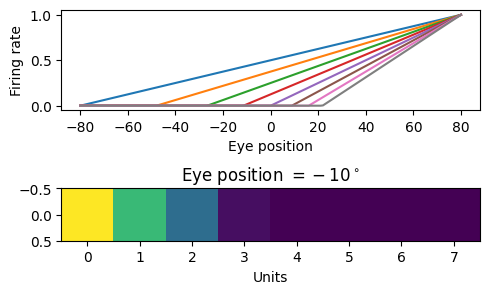

In [51]:
figure(figsize=(5,3))
subplot(2,1,1); plot(x, y'); xlabel("Eye position"); ylabel("Firing rate")
subplot(2,1,2); imshow(eye_pos_encoded[:, :]'); title(L"Eye position $=-10^\circ$"); xlabel("Units") 
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```